Successfully generated original audio: 2_PREPROCESS_OUT/AUDIO/velocity_test_69/velocity_test_69_Yamaha_S6.wav
Note 69 gain: 0.2140225410461426

Summed audio saved to: 2_PREPROCESS_OUT/AUDIO/velocity_test_69/velocity_test_69_Yamaha_S6_pre.wav


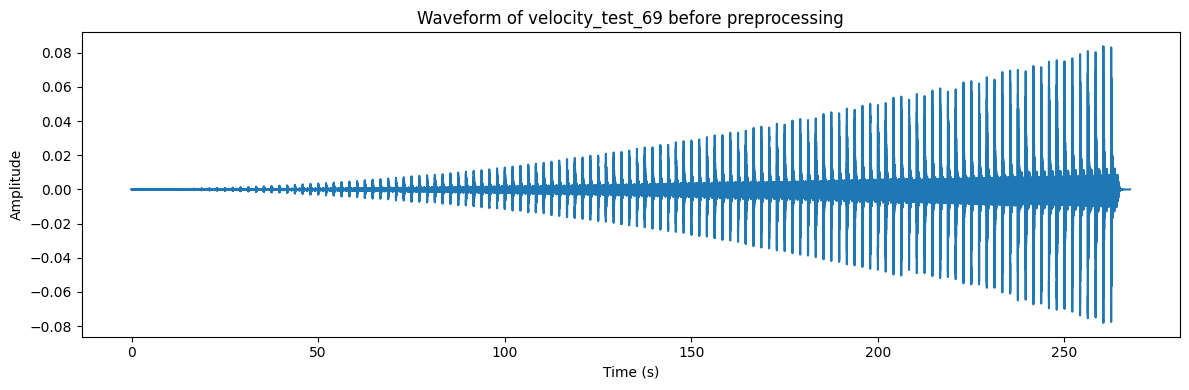

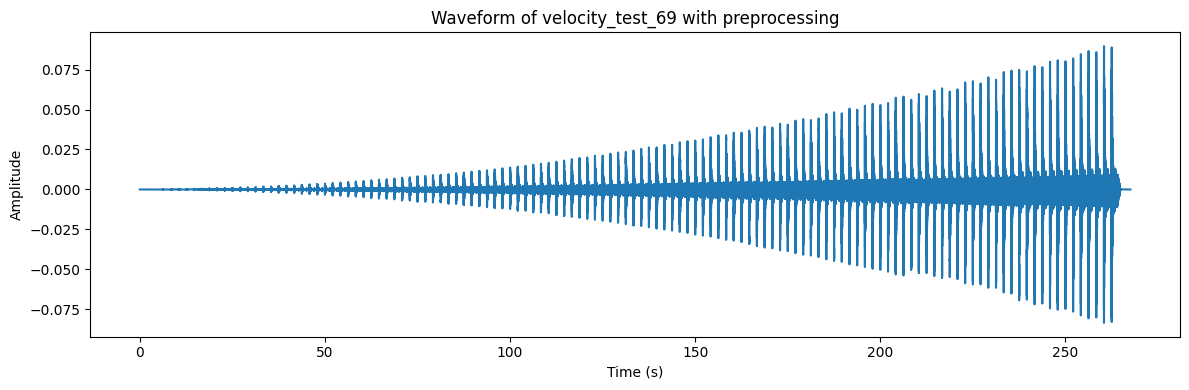

In [4]:
import os
import librosa
import soundfile as sf
import numpy as np
import subprocess
from mido import MidiFile, MidiTrack, Message
import matplotlib.pyplot as plt
import audioread

# --- Global Variables ---
soundfont = "Yamaha_S6"
midi_name = "velocity_test_69"

soundfont_path = os.path.join("SOURCES/SOUNDFONTS/", soundfont + ".sf2")
midi_path = os.path.join("SOURCES/MIDI/", midi_name + ".midi")
gains_path = os.path.join("SOURCES/SF_GAINS/", f"{soundfont}_gains.txt")

outputs_path = "2_PREPROCESS_OUT/"
audio_path = os.path.join(outputs_path, f"AUDIO/{midi_name}/")
segment_path = os.path.join(outputs_path, f"SEGMENTS/{midi_name}_{soundfont}/")
os.makedirs(audio_path, exist_ok=True)
os.makedirs(segment_path, exist_ok=True)

original_audio = os.path.join(audio_path, f"{midi_name}_{soundfont}.wav")
preprocess_audio = os.path.join(audio_path, f"{midi_name}_{soundfont}_pre.wav")

# --- Functions ---
def segment_note(original_midi_path, target_note):
    """
    Creates a new MIDI file containing only the specified note events,
    and ensures other notes are turned off. It first checks if the
    target note exists in the MIDI file.
    """
    output_midi = os.path.join(segment_path, f"{target_note}.mid")
    note_found = False

    try:
        mid = MidiFile(original_midi_path)
    except FileNotFoundError:
        print(f"Error: MIDI file not found at '{original_midi_path}'")
        return None

    # First pass: Check if the target note exists
    for track in mid.tracks:
        for msg in track:
            if msg.type == 'note_on' and msg.note == target_note:
                note_found = True
                break
        if note_found:
            break

    if not note_found:
        print(f"Warning: Note {target_note} not found in MIDI file.")
        return None

    new_mid = MidiFile(ticks_per_beat=mid.ticks_per_beat)

    for track in mid.tracks:
        new_track = MidiTrack()
        new_mid.tracks.append(new_track)

        for msg in track:
            if msg.type == 'note_on':
                if msg.note == target_note:
                    new_track.append(msg)
                else:
                    new_track.append(Message('note_off', note=msg.note, velocity=0, time=msg.time))
            elif msg.type == 'note_off':
                new_track.append(msg)
            else:
                new_track.append(msg)

    try:
        new_mid.save(output_midi)
        return output_midi
    except Exception as e:
        print(f"An error occurred while saving the segmented MIDI: {e}")
        return None

def sum_audio_segments(audio_segments):
    """Sums a list of audio segments together.

    Args:
        audio_segments (list of numpy.ndarray): A list of audio data arrays.
            It is assumed that all segments have the same sample rate.

    Returns:
        numpy.ndarray: The summed audio signal.
    """
    if not audio_segments:
        return np.array([])

    # Ensure all segments have the same length by padding with zeros
    max_len = max(len(seg) for seg in audio_segments)
    padded_segments = [np.pad(seg, (0, max_len - len(seg)), 'constant') for seg in audio_segments]

    # Sum the padded segments
    summed_audio = np.sum(padded_segments, axis=0)
    return summed_audio

def load_audio(path, sr=22050, mono=True, offset=0.0, duration=None,
               dtype=np.float32, res_type='kaiser_best',
               backends=[audioread.ffdec.FFmpegAudioFile]):
    """Load audio using ffmpeg backend."""
    y = []
    try:
        with audioread.audio_open(os.path.realpath(path), backends=backends) as input_file:
            sr_native = input_file.samplerate
            n_channels = input_file.channels

            s_start = int(np.round(sr_native * offset)) * n_channels
            s_end = np.inf if duration is None else s_start + (int(np.round(sr_native * duration)) * n_channels)

            n = 0
            for frame in input_file:
                frame = librosa.util.buf_to_float(frame, dtype=dtype)
                n_prev = n
                n += len(frame)

                if n < s_start:
                    continue
                if s_end < n_prev:
                    break
                if s_end < n:
                    frame = frame[:s_end - n_prev]
                if n_prev <= s_start <= n:
                    frame = frame[(s_start - n_prev):]

                y.append(frame)

        if y:
            y = np.concatenate(y)
            if n_channels > 1:
                y = y.reshape((-1, n_channels)).T
                if mono:
                    y = librosa.to_mono(y)
            if sr is not None and sr != sr_native:
                y = librosa.resample(y, orig_sr=sr_native, target_sr=sr, res_type=res_type)
            current_sr = sr_native if sr is None else sr
        else:
            y = np.array([], dtype=dtype)
            current_sr = sr

        return y, current_sr

    except audioread.NoBackendError:
        print("Error: No audio backend found. Ensure you have ffmpeg or another backend installed.")
        return np.array([]), sr
    except FileNotFoundError:
        print(f"Error: Audio file not found at '{path}'")
        return np.array([]), sr
    except Exception as e:
        print(f"An error occurred while loading audio '{path}': {e}")
        return np.array([]), sr

def load_gains(file_path):
    """
    Loads note gains from a text file into a dictionary.
    """
    gains = {}
    try:
        with open(file_path, 'r') as f:
            next(f)  # Skip the header line
            for line in f:
                line = line.strip()
                if line:
                    try:
                        note_str, gain_str = line.split('\t')
                        note = int(note_str)
                        gain = float(gain_str)
                        gains[note] = gain
                    except ValueError:
                        print(f"Warning: Skipping malformed line in '{file_path}': {line}")
    except FileNotFoundError:
        print(f"Error: Gain file not found at '{file_path}'")
    except Exception as e:
        print(f"An error occurred while reading '{file_path}': {e}")
    return gains

# --- Main Execution ---
gains = load_gains(gains_path)
notes = list(range(21, 109))  # Corrected range to include note 108
generated_audio_segments = []
preprocess_sample_rate = None

# Generate the original audio
cmd_original = ["fluidsynth", "-ni", soundfont_path, midi_path, "-F", original_audio, "-r", "44100"]
try:
    subprocess.run(cmd_original, check=True)
    print(f"Successfully generated original audio: {original_audio}")
except subprocess.CalledProcessError as e:
    print(f"Error generating original WAV file: {e}")
except FileNotFoundError:
    print(f"Error: Soundfont file not found at {soundfont_path}")

for note in notes:
    segment_midi_path = segment_note(midi_path, note)

    if segment_midi_path:
        gain_value = gains.get(note)
        if gain_value is not None:
            gain_str = str(0.2 * gain_value)
            print(f"Note {note} gain: {gain_str}")

            note_segment_path = os.path.join(segment_path, f"{note}.wav")
            cmd_segment = ["fluidsynth", "-ni", soundfont_path, segment_midi_path, "-F", note_segment_path, "-r", "44100", "-g", gain_str]
            try:
                subprocess.run(cmd_segment, check=True)
                segment_audio_data, segment_sample_rate = load_audio(note_segment_path)

                if segment_audio_data.size > 0 and segment_sample_rate is not None:
                    generated_audio_segments.append(segment_audio_data)
                    if preprocess_sample_rate is None:
                        preprocess_sample_rate = segment_sample_rate
                    elif preprocess_sample_rate != segment_sample_rate:
                        raise ValueError("Sample rates of audio segments do not match.")
                os.remove(segment_midi_path)
                os.remove(note_segment_path)

            except subprocess.CalledProcessError as e:
                print(f"Error generating WAV file for note {note}: {e}")
            except FileNotFoundError:
                print(f"Error: Soundfont file not found at {soundfont_path}")
            except ValueError as e:
                print(e)
                break # Stop processing if sample rates mismatch
        else:
            #print(f"Warning: No gain defined for note {note}")
            # Consider using a default gain here if needed
            note_segment_path = os.path.join(segment_path, f"{note}.wav")
            cmd_segment = ["fluidsynth", "-ni", soundfont_path, segment_midi_path, "-F", note_segment_path, "-r", "44100"] # No gain applied
            try:
                subprocess.run(cmd_segment, check=True)
                segment_audio_data, segment_sample_rate = load_audio(note_segment_path)
                if segment_audio_data.size > 0 and segment_sample_rate is not None:
                    generated_audio_segments.append(segment_audio_data)
                    if preprocess_sample_rate is None:
                        preprocess_sample_rate = segment_sample_rate
                    elif preprocess_sample_rate != segment_sample_rate:
                        raise ValueError("Sample rates of audio segments do not match.")
                os.remove(segment_midi_path)
                os.remove(note_segment_path)
            except subprocess.CalledProcessError as e:
                print(f"Error generating WAV file for note {note} (no gain): {e}")
            except FileNotFoundError:
                print(f"Error: Soundfont file not found at {soundfont_path}")
            except ValueError as e:
                print(e)
                break

if generated_audio_segments and preprocess_sample_rate is not None:
    preprocess_audio_data = sum_audio_segments(generated_audio_segments)
    sf.write(preprocess_audio, preprocess_audio_data, preprocess_sample_rate)
    print(f"\nSummed audio saved to: {preprocess_audio}")
else:
    print("\nNo audio segments were generated or sample rate was not determined.")

# Plot original audio waveform
if os.path.exists(original_audio):
    original_audio_data, original_sample_rate = load_audio(original_audio)
    if original_audio_data.size > 0 and original_sample_rate is not None:
        time_axis = np.linspace(0, len(original_audio_data) / original_sample_rate, num=len(original_audio_data))
        plt.figure(figsize=(12, 4))
        plt.plot(time_axis, original_audio_data)
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.title(f"Waveform of {midi_name} before preprocessing")
        plt.tight_layout()
        plt.show()
    else:
        print("Warning: Could not load or plot original audio.")
else:
    print(f"Warning: Original audio file not found at {original_audio}")

# Plot preprocessed audio waveform
if os.path.exists(preprocess_audio):
    preprocess_audio_data, preprocess_sample_rate = load_audio(preprocess_audio)
    if preprocess_audio_data.size > 0 and preprocess_sample_rate is not None:
        time_axis = np.linspace(0, len(preprocess_audio_data) / preprocess_sample_rate, num=len(preprocess_audio_data))
        plt.figure(figsize=(12, 4))
        plt.plot(time_axis, preprocess_audio_data)
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.title(f"Waveform of {midi_name} with preprocessing")
        plt.tight_layout()
        plt.show()
    else:
        print("Warning: Could not load or plot preprocessed audio.")
else:
    print(f"Warning: Preprocessed audio file not found at {preprocess_audio}")